# Лабораторная работа №4. Часть 2. Выбор параметров модели и кросс-валидация 
Главная задача обучаемых алгоритмов – их способность *обобщаться*, то есть хорошо работать на новых данных. Поскольку, на новых данных мы сразу не можем проверить качество построенной модели (нам ведь надо для них сделать прогноз, то есть истинных значений целевого признака мы для них не знаем), то надо пожертвовать небольшой порцией данных, чтоб на ней проверить качество модели. 

Чаще всего это делается одним из 2 способов:

 - отложенная выборка (*held-out/hold-out set*). При таком подходе мы оставляем какую-то долю обучающей выборки (как правило от 20% до 40%), обучаем модель на остальных данных (60-80% исходной выборки) и считаем некоторую метрику качества модели (например, самое простое – долю правильных ответов в задаче классификации) на отложенной выборке. 
 - кросс-валидация (*cross-validation*, на русский еще переводят как скользящий или перекрестный контроль). Тут самый частый случай – K-fold кросс-валидация
 <img src='img/cross_validation.png'><br>
 
Тут модель обучается K раз на разных (K-1) подвыборках исходной выборки (белый цвет), а проверяется на одной подвыборке (каждый раз на разной, оранжевый цвет). 
Получаются $K$ оценок качества модели, которые обычно усредняются, выдавая среднюю оценку качества классификации/регресии на кросс-валидации.

Кросс-валидация дает лучшую по сравнению отложенной выборкой оценку качества модели на новых данных. Но кросс-валидация вычислительно дорогостоящая, если данных много. 

Кросс-валидация – очень важная техника в машинном обучении (применяемая также в статистике и эконометрике), с ее помощью выбираются гиперпараметры моделей, сравниваются модели между собой, оценивается полезность новых признаков в задаче и т.д. Более подробно можно почитать, например, [тут](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part1.html) у Sebastian Raschka или в любом классическом учебнике по машинному (статистическому) обучению

## Деревья решений и метод ближайших соседей в задаче распознавания рукописных цифр MNIST

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

Подключим нужные классы и вспомогательные функции.

In [2]:
# Используемые классификаторы
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Функция метрики качества обучения
from sklearn.metrics import accuracy_score

# Функции разбиения на подвыборки и кросс-валидации
from sklearn.model_selection import train_test_split, StratifiedKFold

# Функции для подбора параметров и оценки качества при кросс-валидации
from sklearn.model_selection import GridSearchCV, cross_val_score

Теперь посмотрим на описанные 2 алгоритма в реальной задаче. Используемый "встроенные" в `sklearn` данные по рукописным цифрам. Эта задача будет примером, когда метод ближайших соседей работает на удивление хорошо.

In [3]:
from sklearn.datasets import load_digits

Загружаем данные.

In [4]:
data = load_digits()
X, y = data.data, data.target

Картинки здесь представляются матрицей 8 x 8 (интенсивности белого цвета для каждого пикселя). Далее эта матрица "разворачивается" в вектор длины 64, получается признаковое описание объекта.

In [5]:
X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Нарисуем несколько рукописных цифр, видим, что они угадываются.

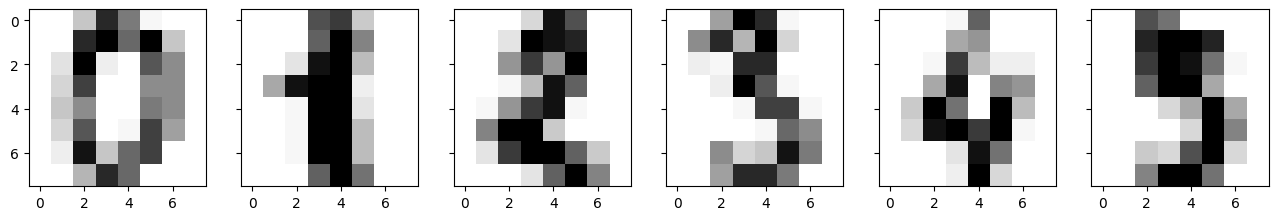

In [6]:
n = 6
f, axes = plt.subplots(1, n, sharey=True, figsize=(16,6))
for i in range(n):    
    axes[i].imshow(X[i,:].reshape([8,8]), cmap='Greys');

Посмотрим на соотношение классов в выборке, видим, что примерно поровну нулей, единиц, ..., девяток.

In [7]:
np.bincount(y)

array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180])

Выделим 70% выборки (X_train, y_train) под обучение и 30% будут отложенной выборкой (X_holdout, y_holdout). отложенная выборка никак не будет участвовать в настройке параметров модели, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [8]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

Обучим 2 модели – дерево решений и kNN, пока не знаем, какие параметры хороши, поэтому наугад: глубину дерева берем 5, число ближайших соседей – 10.

In [9]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [10]:
%%time
tree.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 12.6 ms


DecisionTreeClassifier(max_depth=5, random_state=17)

In [11]:
%%time
knn.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 1.2 ms


KNeighborsClassifier(n_neighbors=10)

Сделаем прогнозы для отложенной выборки. Качество прогнозов будем проверять с помощью простой метрики – доли правильных ответов (функцией `accuracy_score`). Видим, что метод ближайших соседей справился намного лучше. Но это мы пока выбирали параметры наугад.

In [12]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
print(f"kNN accuracy = {accuracy_score(y_holdout, knn_pred)}")
print(f"Tree accuracy = {accuracy_score(y_holdout, tree_pred)}")

kNN accuracy = 0.9740740740740741
Tree accuracy = 0.6666666666666666


  File "C:\Users\pavel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.496.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.496.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                    

Теперь настроим параметры дерева на кросс-валидации. Настраивать будем максимальную глубину и максимальное используемое на каждом разбиении число признаков. Суть того, как работает GridSearchCV: для каждой уникальной пары значений  параметров `max_depth` и `max_features` будет проведена 5-кратная кросс-валидация и выберется лучшее сочетание параметров.

In [13]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
               'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

In [14]:
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [15]:
print(f"Best tree parameters: {tree_grid.best_params_}")
print(f"with best score={tree_grid.best_score_}")

Best tree parameters: {'max_depth': 10, 'max_features': 50}
with best score=0.8568203376968316


На отложенной выборке:

In [16]:
print(f"Best tree accuracy = {accuracy_score(y_holdout, tree_grid.predict(X_holdout))}")

Best tree accuracy = 0.8425925925925926


Это уже не 66%, но и не 97%. Метод ближайших соседей на этом наборе данных работает лучше. В случае одного ближайшего соседа на кросс-валидации достигается почти 99% угадываний.

In [17]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5))

np.float64(0.9864858028204642)

In [18]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
print(f"kNN accuracy with k = 1: {accuracy_score(y_holdout, knn.predict(X_holdout))}")

kNN accuracy with k = 1: 0.9833333333333333


И это действительно наилучший вариант (при поиске в диапазоне от 1 до 10 ближайших соседей:

In [19]:
knn_params = {'n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn, knn_params, cv=5, n_jobs=-1, verbose=True)
knn_grid.fit(X_train, y_train)
print(f"Best kNN parameters: {knn_grid.best_params_}")
print(f"with best score={knn_grid.best_score_}")
print(f"Best tree accuracy = {accuracy_score(y_holdout, knn_grid.predict(X_holdout))}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best kNN parameters: {'n_neighbors': 1}
with best score=0.9864858028204642
Best tree accuracy = 0.9833333333333333


**Общий совет:** в начале проверяйте на своих данных простые модели – дерево решений и метод ближайших соседей (в следующий раз сюда добавится логистическая регрессия), может оказаться, что уже они работают достаточно хорошо. 

## Плюсы и минусы деревьев решений

**Плюсы:**
 - Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;
 - Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" (строгого определения я не видел) как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);
 - Быстрые процессы обучения и прогнозирования;
 - Малое число параметров модели;
 - Поддержка и числовых, и категориальных признаков.
 
**Минусы:**
 - У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов), поэтому и правила классификации могут сильно изменяться, что ухудшает интерпретируемость модели;
 - Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;
 - Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением. Впрочем, переобучение - проблема всех методов машинного обучения;
 - Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений (рассмотрим далее);
 - Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева;
 - Сложно поддерживаются пропуски в данных. Friedman оценил, что на поддержку пропусков в данных ушло около 50% кода CART (классический алгоритм построения деревьев классификации и регрессии – Classification And Regression Trees, в `sklearn` реализована улучшенная версия именно этого алгоритма);
 - Модель умеет только интерполировать, но не  экстраполировать (это же верно и для леса и бустинга на деревьях). То есть дерево решений делает константный прогноз для объектов, находящихся в признаковом пространстве вне параллелепипеда, охватывающего все объекты обучающей выборки. В нашем примере с желтыми и синими шариками это значит, что модель дает одинаковый прогноз для всех шариков с координатой > 19 или < 0.

### Плюсы и минусы метода ближайших соседей

Плюсы:
 - Простая реализация
 - Можно адаптировать под нужную задачу выбором метрики или ядра (в двух словах: ядро может задавать операцию сходства для сложных объектов типа графов, а сам подход kNN остается тем же). ;
 - Неплохая интерпретируемость, можно объяснить, почему тестовый пример был классифицирован именно так. Хотя этот аргумент можно атаковать: если число соседей большое, то интерпретация ухудшается (условно: "мы не дали ему кредит, потому что он похож на 350 клиентов, из которых 70 – плохие, что на 12% больше, чем в среднем по выборке").
 
Минусы:
 - Метод считается быстрым в сравнении, например, с композициями алгоритмов, но в реальных задачах, как правило, число соседей, используемых для классификации, будет большим (100-150), и в таком случае алгоритм будет работать не так быстро, как дерево решений;
 - Если в наборе данных много признаков, то трудно подобрать подходящие веса и определить, какие признаки не важны для классификации/регрессии;
 - Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован. Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени;
 - Нет теоретических оснований выбора определенного числа соседей - только перебор (впрочем, чаще всего это верно для всех гиперпараметров всех моделей). В случае малого числа соседей метод чувствителен к выбросам, то есть склонен переобучаться;
 - Как правило, плохо работает, когда признаков много, из-за "проклятия размерности" [смотрите тут](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

### Сложный случай для деревьев
В продолжение обсуждения плюсов и минусов приведем очень простой пример задачи классификации, с которым дерево справляется, но делает все как-то "сложнее", чем хотелось бы. Создадим множество точек на плоскости (2 признака), каждая точка будет относиться к одному из классов (+1, красные, или -1 – желтые). Если смотреть на это как на задачу классификации, то вроде все очень просто – классы разделяются прямой. 

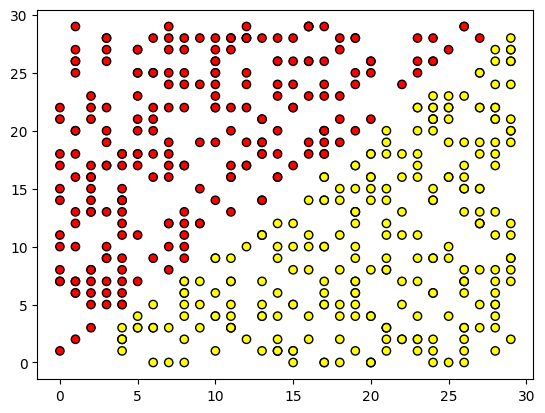

In [20]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)
        
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)


X, y = form_linearly_separable_data()

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black');

Однако дерево решений строит уж больно сложную границу и само по себе оказывается глубоким. Кроме того, представьте, как плохо дерево будет обобщаться на пространство вне представленного квадрата $30 \times 30$, обрамляющего обучающую выборку.

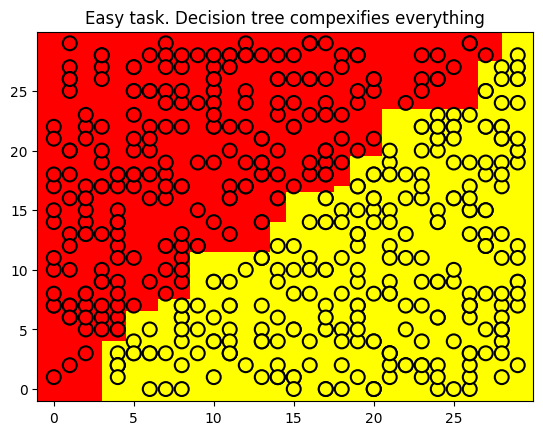

In [21]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))


tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

Вот такая сложная конструкция, хотя решение (хорошая разделяющая поверхность) – это всего лишь прямая $x_1 = x_2$.

In [22]:
from ipywidgets import Image
from io import StringIO
import pydotplus
from sklearn.tree import export_graphviz


dot_data = StringIO()
export_graphviz(tree, feature_names=['x1', 'x2'], 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

InvocationException: GraphViz's executables not found

Метод одного ближайшего соседа здесь справляется вроде лучше дерева, но все же не так хорошо, как линейный классификатор (наша следующая тема).

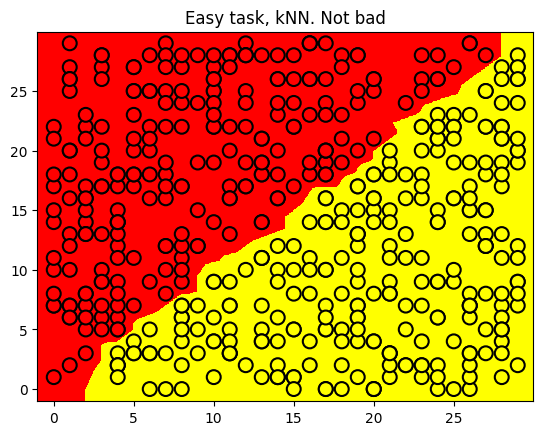

In [23]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.title('Easy task, kNN. Not bad');

### Сложный случай для метода ближайших соседей
Теперь рассмотрим еще один простой пример. В задаче классификации один из признаков будет просто пропорционален вектору ответов, но методу ближайших соседей это не поможет.

In [27]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)
    
    # первый признак пропорционален целевому
    x1 = 0.4 * y
    
    # остальные признаки – шум
    x_other = np.random.random(size=[n_obj, n_feat - 1])
    
    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y

X, y = form_noisy_data()

Как обычно, будем смотреть на долю правильных ответов на кросс-валидации и на отложенной выборке. Построим кривые, отражающие зависимость этих величин от параметра `n_neighbors` в методе ближайших соседей. Такие кривые называются кривыми валидации.

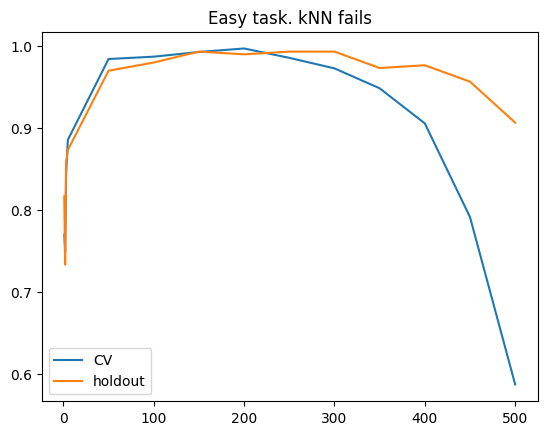

In [28]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend();

In [29]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print('Decision tree. CV: {}, holdout: {}'.format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0


Дерево справилось с задачей идеально, а метод ближайших соседей испытал трудности. Впрочем, это минус скорее не метода, а используемой евклидовой метрики: в данном случае она не позволила выявить, что один признак намного лучше остальных.

Использованы материалы **"Открытого курса по машинному обучению"**. Авторы: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий и Data Scientist в Segmento Екатерина Демидова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.